Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.pandas.set_option('display.max_columns', None)

Read source data

In [4]:
crime = pd.read_csv('Crime_Data.csv')

In [5]:
mocode_mapping = pd.read_csv('mocode_mapping.csv')

In [6]:
crime

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,Vict Age,Vict Sex,Vict Descent,Premis Cd,Premis Desc,Weapon Used Cd,Weapon Desc,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,0,M,O,101.0,STREET,NaN,NaN,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,47,M,O,128.0,BUS STOP/LAYOVER (ALSO QUERY 124),NaN,NaN,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,19,X,X,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,19,M,O,405.0,CLOTHING STORE,NaN,NaN,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,1822 1501 0930 2004,28,M,H,102.0,SIDEWALK,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974472,240710284,07/24/2024 12:00:00 AM,07/23/2024 12:00:00 AM,1400,7,Wilshire,788,1,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,4000 W 23RD ST,NaN,34.0362,-118.3284
974473,240104953,01/15/2024 12:00:00 AM,01/15/2024 12:00:00 AM,100,1,Central,101,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 0400 0416,0,X,X,503.0,HOTEL,500.0,UNKNOWN WEAPON/OTHER WEAPON,IC,Invest Cont,745.0,NaN,NaN,NaN,1300 W SUNSET BL,NaN,34.0685,-118.2460
974474,241711348,07/19/2024 12:00:00 AM,07/19/2024 12:00:00 AM,757,17,Devonshire,1751,2,888,TRESPASSING,1501,0,X,X,885.0,MTA - ORANGE LINE - CHATSWORTH,NaN,NaN,IC,Invest Cont,888.0,NaN,NaN,NaN,10000 OLD DEPOT PLAZA RD,NaN,34.2500,-118.5990
974475,240309674,04/24/2024 12:00:00 AM,04/24/2024 12:00:00 AM,1500,3,Southwest,358,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1822 0334 0416 0445 0449 1202,70,F,W,102.0,SIDEWALK,308.0,STICK,IC,Invest Cont,230.0,NaN,NaN,NaN,FLOWER ST,JEFFERSON BL,34.0215,-118.2868


In [7]:
mocode_mapping

,MO_Code,Description
0,344,Removes victim property
1,329,Vandalized
2,1822,Stranger
3,325,Took merchandise
4,416,Hit with weapon
5,400,Force used
6,1266,Victim was security guard
7,1202,Victim was aged (60 & over) or blind/physicall...
8,1251,Victim was a student
9,444,Pushed


In [8]:
crime.shape

(974477, 28)

In [9]:
crime.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

# Data Cleaning

In [10]:
null_columns = crime.columns[crime.isnull().any()] #shows columns with null values
crime[null_columns].isnull().sum()*100/len(crime) # percentage of null values

,0
Mocodes,14.651552
Vict Sex,13.956512
Vict Descent,13.957538
Premis Cd,0.001437
Premis Desc,0.059930
Weapon Used Cd,66.568529
Weapon Desc,66.568529
Status,0.000103
Crm Cd 1,0.001129
Crm Cd 2,92.943907


Dropping columns based on high null percentages

In [11]:
# dropping these columns because the null percentages in the above table are pretty high and don't add value
crime=crime.drop(['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street','Weapon Used Cd', 'Weapon Desc'],axis=1)

There are 21 Patrol Divisions for LA

In [12]:
crime.rename(columns={'AREA NAME': 'Police Station'}, inplace=True)

Cleaning location column

In [13]:
# Removing leading and trailing spaces
crime['LOCATION'] = crime['LOCATION'].str.strip()

# Replacing consecutive spaces with a single space
crime['LOCATION'] = crime['LOCATION'].str.replace(r'\s+', ' ', regex=True)
crime['LOCATION'] = crime['LOCATION'].replace("7TH","7TH ST")
crime['LOCATION'] = crime['LOCATION'].replace("6TH","6TH ST")

Renaming Victim Age Column

In [14]:
crime.rename(columns={'Vict Age': 'Victim Age'}, inplace=True)

Data imputation for victim age

In [15]:
median_age = crime['Victim Age'].median()

# Replace invalid ages with the median age
crime.loc[(crime['Victim Age'] <= 0) | (crime['Victim Age'] > 100), 'Victim Age'] = median_age

Column rename for victim sex

In [16]:
crime.rename(columns={'Vict Sex': 'Victim Sex'}, inplace=True)

In [17]:
crime['Victim Sex'].value_counts()

,count
Victim Sex,
M,394539
F,350930
X,92893
H,111
-,1


Renaming Victim Sex values

In [18]:
crime['Victim Sex'].replace({'M': 'Male'}, inplace=True)
crime['Victim Sex'].replace({'F': 'Female'}, inplace=True)
crime['Victim Sex'].replace({'X': 'Unknown'}, inplace=True)

In [19]:
crime['Victim Sex'].value_counts()

,count
Victim Sex,
Male,394539
Female,350930
Unknown,92893
H,111
-,1


Imputing Victim Sex with most frequent occurring value

In [20]:
sex_counts = crime['Victim Sex'].value_counts()

# Determine the replacement value based on the most frequent value
replacement_value = sex_counts.idxmax()

# Replace 'H' and '-' with the determined replacement value
crime['Victim Sex'].replace({'H': replacement_value}, inplace=True)
crime['Victim Sex'].replace({'-': replacement_value}, inplace=True)

# Impute null values in 'Victim Sex' with the most frequent value
crime['Victim Sex'].fillna(replacement_value, inplace=True)

In [21]:
crime['Victim Sex'].value_counts()

,count
Victim Sex,
Male,530654
Female,350930
Unknown,92893


Renaming Vict Descent to Victim Ethnicity

In [22]:
crime.rename(columns={'Vict Descent': 'Victim Ethnicity'}, inplace=True)

# Defining mapping of Victim Ethnicity values to categories

In [23]:
descent_mapping = {
    'A': 'Other Asian',
    'B': 'Black',
    'C': 'Chinese',
    'D': 'Cambodian',
    'F': 'Filipino',
    'G': 'Guamanian',
    'H': 'Hispanic/Latin/Mexican',
    'I': 'American Indian/Alaskan Native',
    'J': 'Japanese',
    'K': 'Korean',
    'L': 'Laotian',
    'O': 'Other',
    'P': 'Pacific Islander',
    'S': 'Samoan',
    'U': 'Hawaiian',
    'V': 'Vietnamese',
    'W': 'White',
    'X': 'Unknown',
    'Z': 'Asian Indian',
    '-': 'Unknown'  # Replacing '-' with 'Unknown'
}

# Replace values in 'Victim Ethnicity' column using the mapping
crime['Victim Ethnicity'] = crime['Victim Ethnicity'].replace(descent_mapping)

print(crime['Victim Ethnicity'].value_counts())

Victim Ethnicity
Hispanic/Latin/Mexican            291256
White                             195759
Black                             133656
Unknown                           101622
Other                              76222
Other Asian                        20955
Korean                              5581
Filipino                            4467
Chinese                             4161
Japanese                            1456
Vietnamese                          1097
American Indian/Alaskan Native       952
Asian Indian                         518
Pacific Islander                     273
Hawaiian                             208
Cambodian                             85
Guamanian                             71
Laotian                               71
Samoan                                54
Name: count, dtype: int64


Impute null values in 'Victim Ethnicity' with the most frequent value

In [24]:
most_frequent_category = crime['Victim Ethnicity'].mode()[0]
crime['Victim Ethnicity'].fillna(most_frequent_category, inplace=True)

Filling descriptions for MO (method of crime)


In [25]:
crime['Mocodes'].fillna('UNKNOWN', inplace=True)

In [26]:
mocode_groups = dict(zip(mocode_mapping['MO_Code'], mocode_mapping['Description']))

# Function to categorize Mocodes
def categorize_mocode(mocode):
    for key in mocode_groups:
        if str(key) in mocode:
            return mocode_groups[key]
    return 'Other'

# Apply the categorization
crime['Crime Method'] = crime['Mocodes'].apply(categorize_mocode)

crime['Crime Method'].value_counts()

,count
Crime Method,
Removes victim property,287904
Other,272569
Stranger,159033
Vandalized,100067
Hit with weapon,75249
Force used,23068
Took merchandise,18075
Pushed,11840
Gangs,7722


In [27]:
status_mapping = {
    'IC': 'Investigation Continued',
    'AO': 'Adult Other',
    'AA': 'Adult Arrest',
    'JA': 'Juvenile Arrest',
    'JO': 'Juvenile Other',
    'CC': 'Criminal Complaint'
}

# Replace status values with their meanings
crime['Status'].replace(status_mapping, inplace=True)

Renaming Date & time columns

In [28]:
crime.rename(columns={'Date Rptd': 'Date Reported'}, inplace=True)

In [29]:
crime.rename(columns={'DATE OCC': 'Date Occured'}, inplace=True)

In [30]:
crime.rename(columns={'TIME OCC': 'Time Occured'}, inplace=True)

Extracting Day, Month, year from date column

In [31]:
from datetime import datetime

In [32]:
# Convert 'Date Reported and Occured' column to datetime format
crime['Date Reported'] = pd.to_datetime(crime['Date Reported'], errors='coerce')
crime['Date Occured'] = pd.to_datetime(crime['Date Occured'], errors='coerce')

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Select only numeric columns for correlation calculation
numeric_crime = crime.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_crime.corr()

correlation_matrix

,DR_NO,Time Occured,AREA,Rpt Dist No,Part 1-2,Crm Cd,Victim Age,Premis Cd,Crm Cd 1,LAT,LON
DR_NO,1.000000,-0.005480,0.038157,0.038393,-0.025208,-0.019399,-0.022892,0.030512,-0.019265,0.045944,-0.044716
Time Occured,-0.005480,1.000000,0.000951,0.001072,-0.055545,0.012211,-0.023713,-0.062907,0.012216,0.002952,-0.002684
AREA,0.038157,0.000951,1.000000,0.999049,0.007562,-0.005052,0.033285,-0.004638,-0.005262,0.024497,-0.009992
Rpt Dist No,0.038393,0.001072,0.999049,1.000000,0.007409,-0.005164,0.033382,-0.004823,-0.005374,0.024251,-0.009929
Part 1-2,-0.025208,-0.055545,0.007562,0.007409,1.000000,0.700239,0.075310,0.276537,0.700722,-0.028264,0.028734
Crm Cd,-0.019399,0.012211,-0.005052,-0.005164,0.700239,1.000000,-0.011234,0.115659,0.999318,-0.039193,0.039293
Victim Age,-0.022892,-0.023713,0.033285,0.033382,0.075310,-0.011234,1.000000,0.082300,-0.010684,-0.000341,0.001609
Premis Cd,0.030512,-0.062907,-0.004638,-0.004823,0.276537,0.115659,0.082300,1.000000,0.115612,-0.005794,0.007160
Crm Cd 1,-0.019265,0.012216,-0.005262,-0.005374,0.700722,0.999318,-0.010684,0.115612,1.000000,-0.039254,0.039348
LAT,0.045944,0.002952,0.024497,0.024251,-0.028264,-0.039193,-0.000341,-0.005794,-0.039254,1.000000,-0.998260


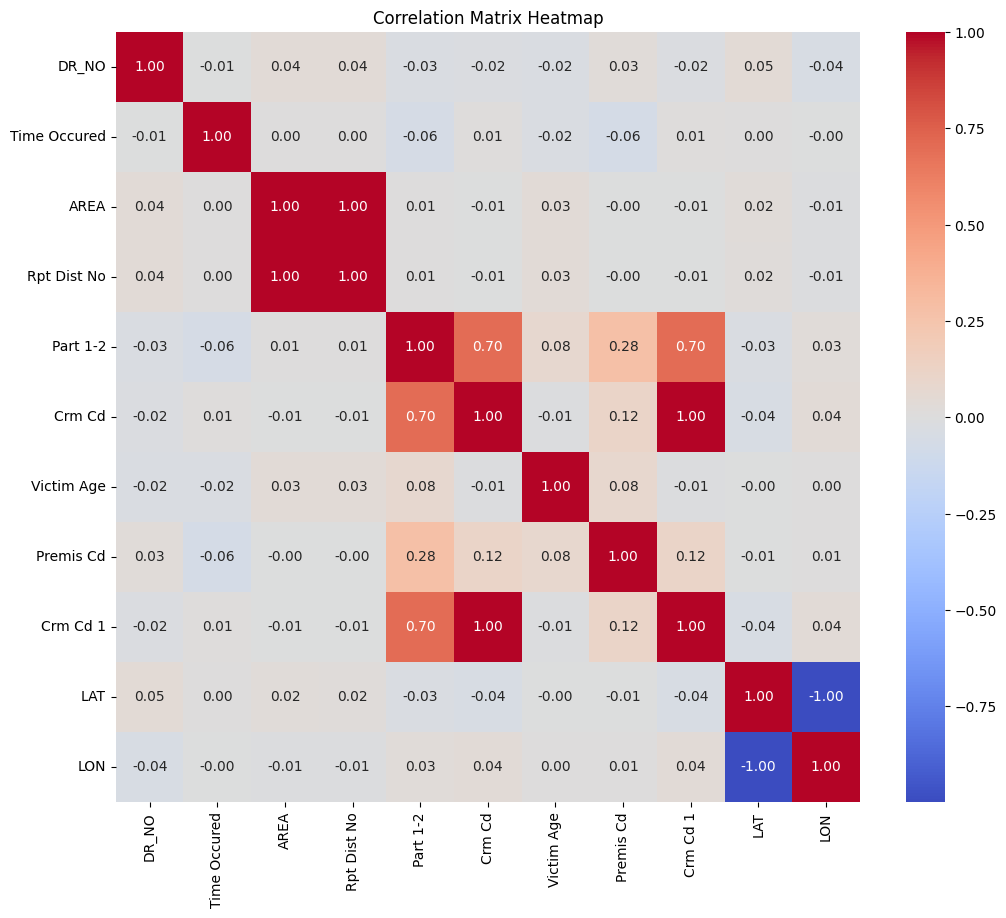

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Select only numeric columns for correlation calculation
numeric_crime = crime.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_crime.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [35]:
# Extracting features from date/time columns
crime['Reported_Day'] = crime['Date Reported'].dt.day
crime['Reported_Month'] = crime['Date Reported'].dt.month
crime['Reported_Year'] = crime['Date Reported'].dt.year

In [36]:
crime['Occurred_Day'] = crime['Date Occured'].dt.day
crime['Occurred_Month'] = crime['Date Occured'].dt.month
crime['Occurred_Year'] = crime['Date Occured'].dt.year

Extracting weekend where  (Monday=0 to Sunday=6)

In [37]:
crime['Is_Weekend'] = crime['Date Reported'].dt.dayofweek.isin([5, 6]).astype(int)

In [38]:
crime.rename(columns={'Premis Desc': 'Crime Location Type'}, inplace=True)

In [39]:
# Fill null values with the most frequent value
most_frequent_value = crime['Crime Location Type'].mode().iloc[0]
crime['Crime Location Type'].fillna(most_frequent_value, inplace=True)

In [40]:
crime['Crime Location Type'].value_counts()

,count
Crime Location Type,
STREET,251508
SINGLE FAMILY DWELLING,161162
"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",116761
PARKING LOT,67151
OTHER BUSINESS,46329
...,...
MTA - SILVER LINE - DOWNTOWN STREET STOPS,2
HORSE RACING/SANTA ANITA PARK*,2
MTA - SILVER LINE - LAC/USC MEDICAL CENTER,2


In [41]:
crime.rename(columns={'Premis Cd': 'Crime Location Code'}, inplace=True)

In [42]:
crime['Crime Location Code'].isna().sum()

14

In [43]:
crime['Crime Location Code'].fillna(-1, inplace=True)

In [44]:
crime['Crime Location Code'].unique()

array([101., 128., 502., 405., 102., 501., 248., 750., 751., 203., 108.,
       504., 605., 404., 221., 707., 702., 209., 726., 801., 729., 602.,
       725., 737., 124., 720., 116., 103., 122., 506., 212., 505., 701.,
       112., 710., 120., 406., 721., 145., 503., 735., 604., 109., 712.,
       717., 708., 104., 152., 201., 607., 238., 222., 119., 507., 514.,
       125., 220., 154., 704., 740., 243., 517., 802., 732., 943., 121.,
       111., 804., 207., 518., 301., 127., 403., 210., 733., 510., 603.,
       208., 123., 135., 410., 247., 217., 719., 412., 834., 401., 402.,
       727., 155., 724., 906., 231., 235., 242., 146., 903., 232., 253.,
       949., 706., 868., 252., 118., 254., 218., 156., 202., 511., 409.,
       142., 913., 945., 214., 736., 713., 213., 753., 249., 921., 251.,
       138., 835., 508., 114., 418., 302., 158., 904., 415., 516., 722.,
       755., 229., 241., 106., 408., 117., 946., 256., 417., 709., 515.,
       730., 966., 411., 718., 211., 728., 703., 40

In [45]:
crime.rename(columns={'Crm Cd Desc': 'Crime Description'}, inplace=True)

In [46]:
crime['Crime Description'].value_counts()

,count
Crime Description,
VEHICLE - STOLEN,109088
BATTERY - SIMPLE ASSAULT,74649
BURGLARY FROM VEHICLE,60693
THEFT OF IDENTITY,60290
"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",59116
...,...
BLOCKING DOOR INDUCTION CENTER,6
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO),5
DISHONEST EMPLOYEE ATTEMPTED THEFT,4


In [47]:
crime.rename(columns={'Crm Cd': 'Crime Code'}, inplace=True)

In [48]:
crime.columns

Index(['DR_NO', 'Date Reported', 'Date Occured', 'Time Occured', 'AREA',
       'Police Station', 'Rpt Dist No', 'Part 1-2', 'Crime Code',
       'Crime Description', 'Mocodes', 'Victim Age', 'Victim Sex',
       'Victim Ethnicity', 'Crime Location Code', 'Crime Location Type',
       'Status', 'Status Desc', 'Crm Cd 1', 'LOCATION', 'LAT', 'LON',
       'Crime Method', 'Reported_Day', 'Reported_Month', 'Reported_Year',
       'Occurred_Day', 'Occurred_Month', 'Occurred_Year', 'Is_Weekend'],
      dtype='object')

# **Data Visualization**

Gender Distribution of Crime Victims

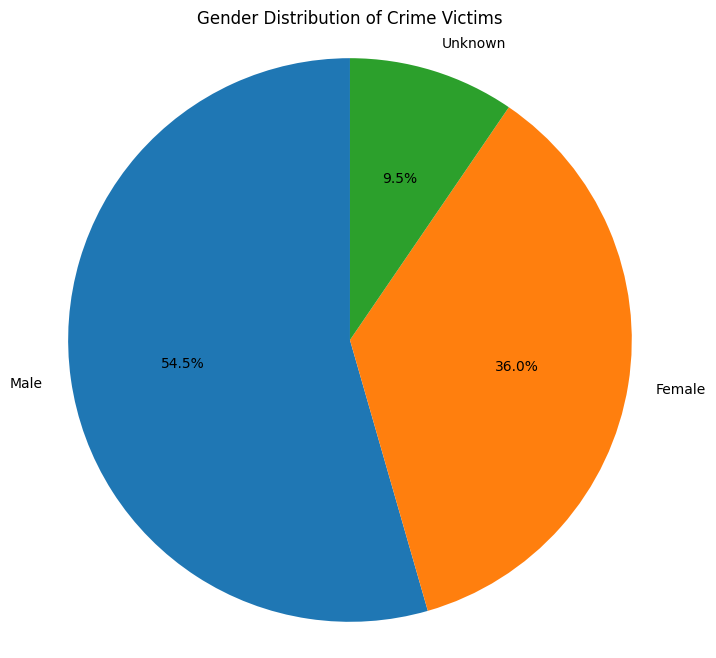

In [49]:
import matplotlib.pyplot as plt
# Calculate the counts of each victim sex
sex_counts = crime['Victim Sex'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution of Crime Victims')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Number of Male and Female Victims by Age Group

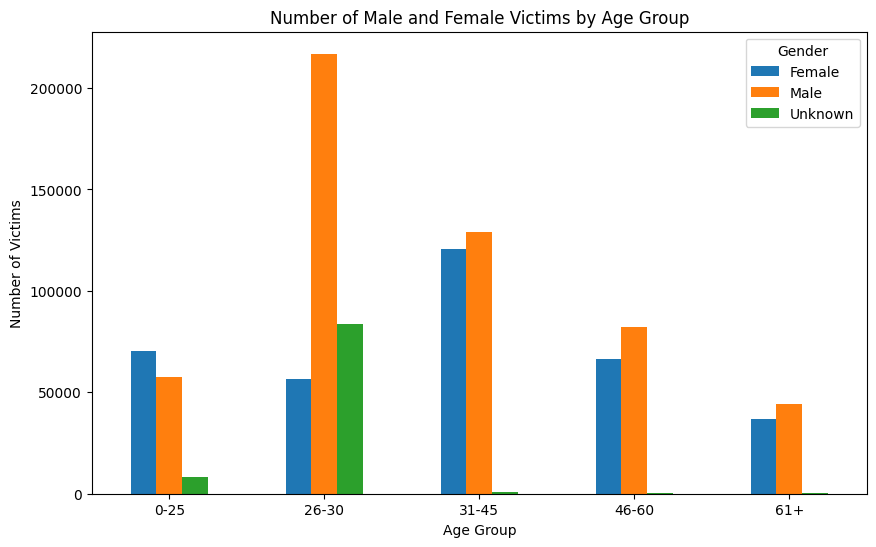

In [50]:
#Number of Male and Female Victims by Age Group
bins = [0, 25, 30, 45, 60, 100]
labels = ['0-25', '26-30', '31-45', '46-60', '61+']
crime['Age_Group'] = pd.cut(crime['Victim Age'], bins=bins, labels=labels)

# Group data by age group and gender and count occurrences
age_gender_counts = crime.groupby(['Age_Group', 'Victim Sex'])['DR_NO'].count().unstack()

# Plot the data
age_gender_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Male and Female Victims by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Victims')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.show()


Ethnicity Distribution of Crime Victims

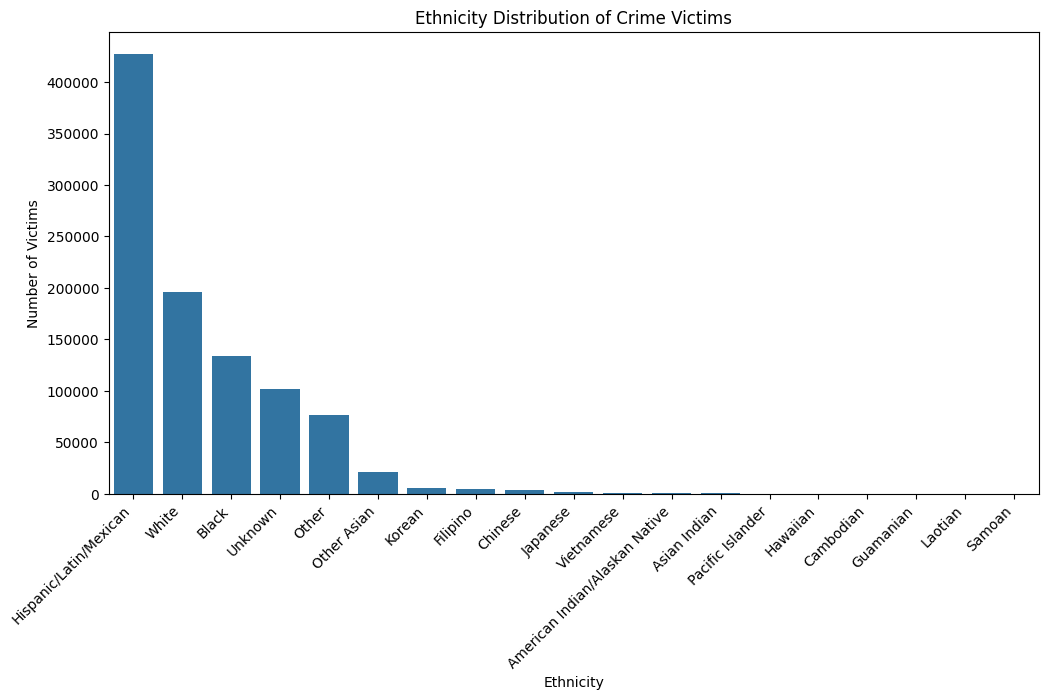

In [51]:
#Ethnicity Distribution of Crime Victims

plt.figure(figsize=(12, 6))
sns.countplot(x='Victim Ethnicity', data=crime, order=crime['Victim Ethnicity'].value_counts().index)
plt.title('Ethnicity Distribution of Crime Victims')
plt.xlabel('Ethnicity')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right')
plt.show()

# Trend by months

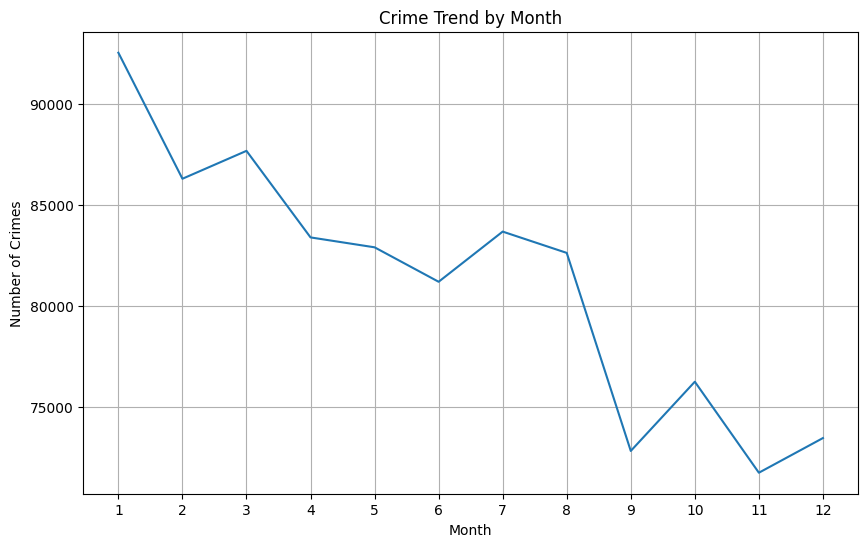

In [52]:
#Trend by months

# Convert 'Date_Occured' to datetime objects
crime['Date Occured'] = pd.to_datetime(crime['Date Occured'])

# Extract the month from the 'Date_Occured' column
crime['Month'] = crime['Date Occured'].dt.month

# Group by month and count the number of crimes
monthly_crime_counts = crime.groupby('Month')['DR_NO'].count()

# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_crime_counts.index, monthly_crime_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.title('Crime Trend by Month')
plt.xticks(range(1, 13))  # Ensure all months are shown on the x-axis
plt.grid(True)
plt.show()


# Trend by Area

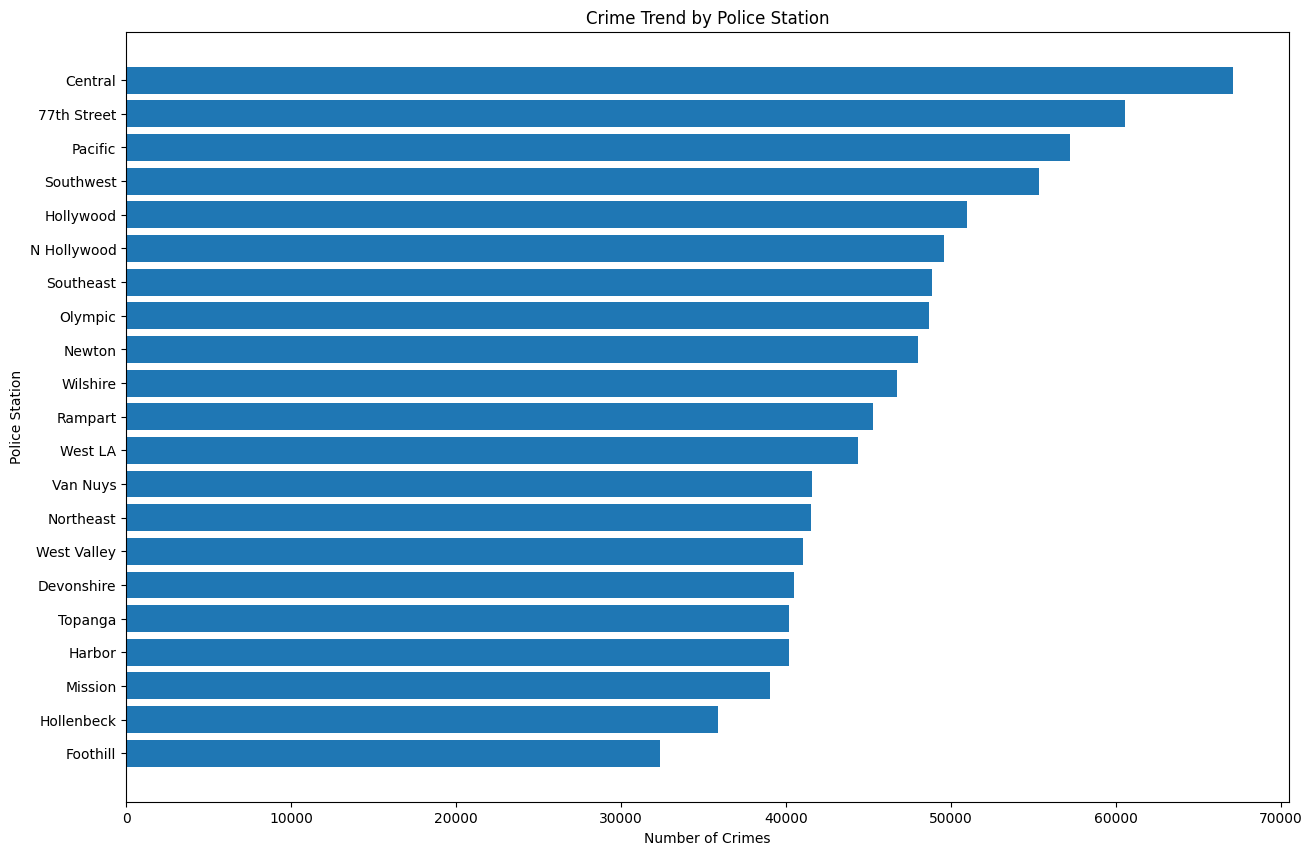

In [53]:
# Group by Area and count the number of crimes
area_crime_counts = crime.groupby('Police Station')['DR_NO'].count()

# Sort the counts in descending order
area_crime_counts = area_crime_counts.sort_values(ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(15, 10))
plt.barh(area_crime_counts.index, area_crime_counts.values)
plt.xlabel('Number of Crimes')
plt.ylabel('Police Station')
plt.title('Crime Trend by Police Station')
plt.show()


# Crime Occurrences by Time Period

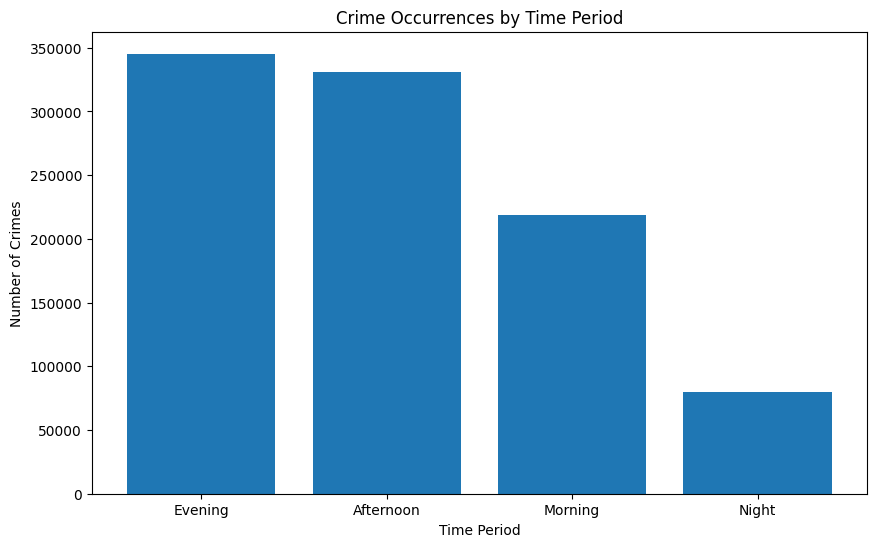

In [54]:

# Convert 'Time_Occured' to datetime objects
crime['Time_Occured_1'] = pd.to_datetime(crime['Time Occured'], format='%H%M', errors='coerce').dt.time
# Create bins for time periods (e.g., morning, afternoon, evening, night)
def categorize_time(time):
  if time is None:
    return 'Unknown'
  if 0 <= time.hour < 6:
    return 'Night'
  elif 6 <= time.hour < 12:
    return 'Morning'
  elif 12 <= time.hour < 18:
    return 'Afternoon'
  else:
    return 'Evening'

crime['Time_Period'] = crime['Time_Occured_1'].apply(categorize_time)
# Count the number of crimes in each time period
time_period_counts = crime['Time_Period'].value_counts()
# Create a bar plot to visualize the distribution
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(time_period_counts.index, time_period_counts.values)
plt.xlabel('Time Period')
plt.ylabel('Number of Crimes')
plt.title('Crime Occurrences by Time Period')
plt.show()
crime.drop(columns=['Time_Occured_1'], inplace=True)

# Crime Method Distribution

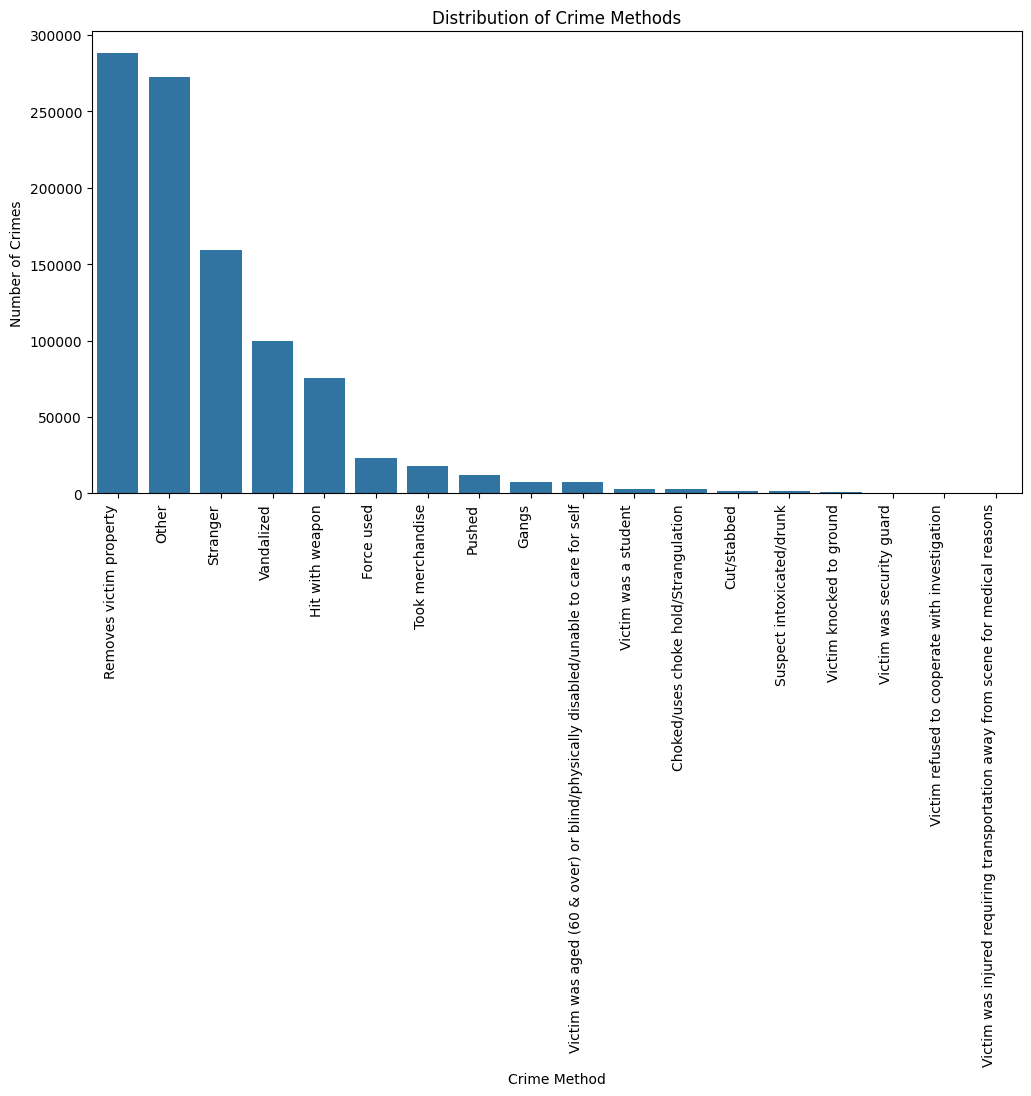

In [55]:
# Crime Method Distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.countplot(x='Crime Method', data=crime, order=crime['Crime Method'].value_counts().index)
plt.title('Distribution of Crime Methods')
plt.xlabel('Crime Method')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90, ha='right')
plt.show()



# Crime Method vs. Time Period

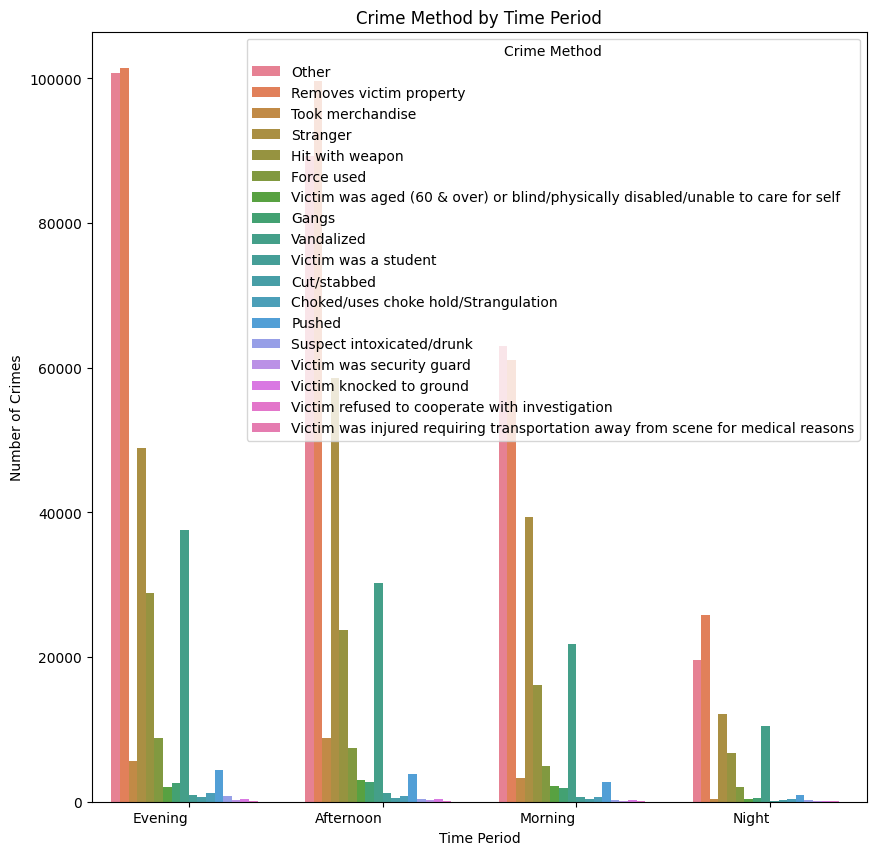

In [56]:
# Crime Method vs. Time Period
plt.figure(figsize=(10,10))
sns.countplot(x='Time_Period', hue='Crime Method', data=crime)
plt.title('Crime Method by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0, ha='right')
plt.legend(title='Crime Method', loc='upper right')
plt.show()

# **Facts Discovered:**

1.) More than half of the victims are males which accounts for nearly 54.5% of the total victims, followed by females.

2.) Maximum crime victims are between the age group of 26 to 30 years.

3.) More than 0.2 million victims are males between the age of 26 to 30 years.

4.) Maximum female victims are in the age group of 31 to 45 years.

5.) Nearly 4,50,000 victims belong to the Hispanic, Latin or Mexican ethnicity.

6.) It is observed that maximum crimes happen in the first month that ie January and the graph can be seen declining towards the end of the year with slight peaks around August and October.

7.) The Central area police station has recorded maximum crime reports whereas, the foothill area can be seen to have least number of crimes.

8.) We can observe that maximum crimes occurred in the evening between 6 pm to 12 am.

In [57]:
crime.columns

Index(['DR_NO', 'Date Reported', 'Date Occured', 'Time Occured', 'AREA',
       'Police Station', 'Rpt Dist No', 'Part 1-2', 'Crime Code',
       'Crime Description', 'Mocodes', 'Victim Age', 'Victim Sex',
       'Victim Ethnicity', 'Crime Location Code', 'Crime Location Type',
       'Status', 'Status Desc', 'Crm Cd 1', 'LOCATION', 'LAT', 'LON',
       'Crime Method', 'Reported_Day', 'Reported_Month', 'Reported_Year',
       'Occurred_Day', 'Occurred_Month', 'Occurred_Year', 'Is_Weekend',
       'Age_Group', 'Month', 'Time_Period'],
      dtype='object')

# LOGISTIC REGRESSION WITH AND WITHOUT REGULARIZATION

In [58]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Assuming 'AREA' and 'Occurred_Month' are relevant features for predicting high/low crime areas.
# Group crime data by month and area, and create a new column 'Crime_Level' for high/low classification
crime_grouped = crime.groupby(['Occurred_Month', 'AREA'])['DR_NO'].count().reset_index()
threshold = crime_grouped['DR_NO'].median()  # Median threshold is set to classify the areas as high vs low crime areas
crime_grouped['Crime_Level'] = (crime_grouped['DR_NO'] > threshold).astype(int)  # 1 for high crime, 0 for low crime

# Prepare data for Logistic Regression
X = crime_grouped[['Occurred_Month', 'AREA']]
y = crime_grouped['Crime_Level']

# One-hot encode 'AREA' (convert categorical variable to binary features)
X = pd.get_dummies(X, columns=['AREA'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression without regularization
logreg_model_l0 = LogisticRegression(random_state=42)
logreg_model_l0.fit(X_train, y_train)

# Predict crime level for the test set
y_pred = logreg_model_l0.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy without Regularization: {round(accuracy, 3)}")

# Print precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"F1-score: {round(f1_score, 3)}")

# Confusion Matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}\n")


# Create and train a Logistic Regression model with L2 regularization (Ridge)
logreg_model = LogisticRegression(penalty='l2', C=0.5, random_state=42)          # L2 regularization (default)
logreg_model.fit(X_train, y_train) #fitting the model to training data

# Predict crime level for the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (L2 Regularization): {round(accuracy, 3)}")

# Print precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"F1-score: {round(f1_score, 3)}")

# Confusion Matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

# Optional: Logistic Regression with L1 regularization (Lasso)
logreg_model_l1 = LogisticRegression(penalty='l1', solver='saga', C=0.5, random_state=42)  # L1 regularization
logreg_model_l1.fit(X_train, y_train) #fitting the model to training data

# Predict and evaluate with L1 regularization
y_pred_l1 = logreg_model_l1.predict(X_test)
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
print(f"\nAccuracy (L1 Regularization): {round(accuracy_l1, 3)}")

# Print precision, recall, and F1-score for L1 regularization
precision_l1, recall_l1, f1_score_l1, _ = precision_recall_fscore_support(y_test, y_pred_l1, average='binary')
print(f"Precision (L1): {round(precision_l1, 3)}")
print(f"Recall (L1): {round(recall_l1, 3)}")
print(f"F1-score (L1): {round(f1_score_l1, 3)}")

# Confusion Matrix for L1
print(f"Confusion Matrix (L1): \n{confusion_matrix(y_test, y_pred_l1)}")

Accuracy without Regularization: 0.843
Precision: 0.8
Recall: 0.8
F1-score: 0.8
Confusion Matrix: 
[[27  4]
 [ 4 16]]

Accuracy (L2 Regularization): 0.902
Precision: 0.8
Recall: 1.0
F1-score: 0.889
Confusion Matrix: 
[[26  5]
 [ 0 20]]

Accuracy (L1 Regularization): 0.843
Precision (L1): 0.773
Recall (L1): 0.85
F1-score (L1): 0.81
Confusion Matrix (L1): 
[[26  5]
 [ 3 17]]


# RANDOM FOREST

In [59]:
#Random Forest for predicting in a given month whether an area will be considered high crime or low crime.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Group crime data by month and area, and create a new column 'Crime_Level' for high/low classification
crime_grouped = crime.groupby(['Occurred_Month', 'AREA'])['DR_NO'].count().reset_index()
threshold = crime_grouped['DR_NO'].median()
crime_grouped['Crime_Level'] = crime_grouped['DR_NO'] > threshold  # True if high crime, False if low crime

# Prepare data for Random Forest
X = crime_grouped[['Occurred_Month', 'AREA']]
y = crime_grouped['Crime_Level']

# One-hot encode 'AREA'
X = pd.get_dummies(X, columns=['AREA'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 5 , 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object for hyperparameter tuning and cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model with hyperparameter tuning and cross-validation
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predict crime level for the test set using the best model
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy, 3)}\n")
#print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Precision: {round(precision,3)}")
print(f"Recall: {round(recall,3)}")
print(f"F1-score: {round(f1_score,3)}")


Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.863

Confusion Matrix:
[[28  3]
 [ 4 16]]
Precision: 0.842
Recall: 0.8
F1-score: 0.821


# KNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

# Group crime data by month and area, and create a new column 'Crime_Level' for high/low classification
crime_grouped = crime.groupby(['Occurred_Month', 'AREA'])['DR_NO'].count().reset_index()
threshold = crime_grouped['DR_NO'].median()  # Adjust threshold if necessary
crime_grouped['Crime_Level'] = (crime_grouped['DR_NO'] > threshold).astype(int)  # Binary classification (1: High, 0: Low)

# Prepare data
X = crime_grouped[['Occurred_Month', 'AREA']]
y = crime_grouped['Crime_Level']

# One-hot encode 'AREA'
X = pd.get_dummies(X, columns=['AREA'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# different numbers of neighbors
for n in range(3, 11,2):  # Loop through n_neighbors from 3 to 10
    print(f"\nEvaluating KNN with {n} neighbors:")

    # Create and train KNN model
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    precision_l1, recall_l1, f1_score_l1, _ = precision_recall_fscore_support(y_test, y_pred_l1, average='binary')
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print("Confusion Matrix:")
    print(f"F1-score: {round(f1_score,3)}")
    print(confusion_matrix(y_test, y_pred))




Evaluating KNN with 3 neighbors:
Accuracy: 0.7450980392156863
Recall: 0.95
Precision: 0.6129032258064516
Confusion Matrix:
F1-score: 0.821
[[19 12]
 [ 1 19]]

Evaluating KNN with 5 neighbors:
Accuracy: 0.7450980392156863
Recall: 0.95
Precision: 0.6129032258064516
Confusion Matrix:
F1-score: 0.821
[[19 12]
 [ 1 19]]

Evaluating KNN with 7 neighbors:
Accuracy: 0.7254901960784313
Recall: 0.95
Precision: 0.59375
Confusion Matrix:
F1-score: 0.821
[[18 13]
 [ 1 19]]

Evaluating KNN with 9 neighbors:
Accuracy: 0.6666666666666666
Recall: 0.95
Precision: 0.5428571428571428
Confusion Matrix:
F1-score: 0.821
[[15 16]
 [ 1 19]]


# Naive Bayes

In [61]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


# Group crime data by month and area, and create a new column 'Crime_Level' for high/low classification
crime_grouped = crime.groupby(['Occurred_Month', 'AREA'])['DR_NO'].count().reset_index()
threshold = crime_grouped['DR_NO'].median()
crime_grouped['Crime_Level'] = crime_grouped['DR_NO'] > threshold  # True if high crime, False if low crime

# Prepare data for Naive Bayes
X = crime_grouped[['Occurred_Month', 'AREA']]
y = crime_grouped['Crime_Level']

# One-hot encode 'AREA'
X = pd.get_dummies(X, columns=['AREA'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Naive Bayes Classifier (GaussianNB)
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision_l1, recall_l1, f1_score_l1, _ = precision_recall_fscore_support(y_test, y_pred_l1, average='binary')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")

print(confusion_matrix(y_test, y_pred))


Accuracy: 0.803921568627451
Precision: 0.7272727272727273
Recall: 0.8
Confusion Matrix:
[[25  6]
 [ 4 16]]


#Evaluating the Results

In [62]:
# Define the data for the table
data = {
    "Model": [
        "Logistic Regression (No Regularization)",
        "Logistic Regression (L2 Regularization)",
        "Logistic Regression (L1 Regularization)",
        "Random Forest",
        "KNN (K=3)",
        "KNN (K=5)",
        "KNN (K=7)",
        "KNN (K=9)",
        "Naïve Bayes"
    ],
    "Accuracy": [
        0.843, 0.902, 0.843, 0.863,
        0.745, 0.745, 0.725, 0.667, 0.804
    ],
    "Precision": [
        0.800, 0.800, 0.773, 0.842,
        0.6129, 0.6129, 0.5938, 0.5429, 0.7273
    ],
    "Recall": [
        0.800, 1.000, 0.850, 0.800,
        0.950, 0.950, 0.950, 0.950, 0.800
    ],
    "F1-Score": [
        0.800, 0.889, 0.810, 0.821,
        None, None, None, None, None
    ],
    "Confusion Matrix": [
        "[[27, 4], [4, 16]]", "[[26, 5], [0, 20]]", "[[26, 5], [3, 17]]",
        "[[28, 3], [4, 16]]", "[[19, 12], [1, 19]]", "[[19, 12], [1, 19]]",
        "[[18, 13], [1, 19]]", "[[15, 16], [1, 19]]", "[[25, 6], [4, 16]]"
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

# Optionally, save the DataFrame to a CSV file
#df.to_csv('model_comparison.csv', index=False)


,Model,Accuracy,Precision,Recall,F1-Score,Confusion Matrix
0,Logistic Regression (No Regularization),0.843,0.8000,0.80,0.800,"[[27, 4], [4, 16]]"
1,Logistic Regression (L2 Regularization),0.902,0.8000,1.00,0.889,"[[26, 5], [0, 20]]"
2,Logistic Regression (L1 Regularization),0.843,0.7730,0.85,0.810,"[[26, 5], [3, 17]]"
3,Random Forest,0.863,0.8420,0.80,0.821,"[[28, 3], [4, 16]]"
4,KNN (K=3),0.745,0.6129,0.95,NaN,"[[19, 12], [1, 19]]"
5,KNN (K=5),0.745,0.6129,0.95,NaN,"[[19, 12], [1, 19]]"
6,KNN (K=7),0.725,0.5938,0.95,NaN,"[[18, 13], [1, 19]]"
7,KNN (K=9),0.667,0.5429,0.95,NaN,"[[15, 16], [1, 19]]"
8,Naïve Bayes,0.804,0.7273,0.80,NaN,"[[25, 6], [4, 16]]"


In [63]:
from tabulate import tabulate

# Define the data for the table
data = [
    ["Logistic Regression (No Regularization)", 0.843, 0.800, 0.800, 0.800, "[[27, 4],\n [4, 16]]"],
    ["Logistic Regression (L2 Regularization)", 0.902, 0.800, 1.000, 0.889, "[[26, 5],\n [0, 20]]"],
    ["Logistic Regression (L1 Regularization)", 0.843, 0.773, 0.850, 0.810, "[[26, 5],\n [3, 17]]"],
    ["Random Forest", 0.863, 0.842, 0.800, 0.821, "[[28, 3],\n [4, 16]]"],
    ["KNN (K=3)", 0.745, 0.612, 0.950, 0.742, "[[19, 12],\n [1, 19]]"],
    ["KNN (K=5)", 0.745, 0.612, 0.950, 0.742, "[[19, 12],\n [1, 19]]"],
    ["KNN (K=7)", 0.725, 0.593, 0.950, 0.723, "[[18, 13],\n [1, 19]]"],
    ["KNN (K=9)", 0.667, 0.542, 0.950, 0.686, "[[15, 16],\n [1, 19]]"],
    ["Naïve Bayes", 0.804, 0.727, 0.800, 0.758, "[[25, 6],\n [4, 16]]"]
]

# Define the table headers
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "Confusion Matrix"]

# Generate the formatted table with multi-line confusion matrices
table = tabulate(data, headers, tablefmt="grid")

# Print the formatted table
print(table)

# Optionally, save the table to a text file for easy copy-pasting into PowerPoint
with open('model_comparison_table.txt', 'w') as f:
    f.write(table)


+-----------------------------------------+------------+-------------+----------+------------+--------------------+
| Model                                   |   Accuracy |   Precision |   Recall |   F1-Score | Confusion Matrix   |
+=========================================+============+=============+==========+============+====================+
| Logistic Regression (No Regularization) |      0.843 |       0.8   |     0.8  |      0.8   | [[27, 4],          |
|                                         |            |             |          |            |  [4, 16]]          |
+-----------------------------------------+------------+-------------+----------+------------+--------------------+
| Logistic Regression (L2 Regularization) |      0.902 |       0.8   |     1    |      0.889 | [[26, 5],          |
|                                         |            |             |          |            |  [0, 20]]          |
+-----------------------------------------+------------+-------------+--